In [223]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from skimage import io
from skimage.util import view_as_windows
from keras.utils import np_utils
from PIL import Image, ImageDraw

sys.path.append('/home/tanuj/Workspace/power-grid-detection')

%matplotlib inline
Image.MAX_IMAGE_PIXELS = None

In [213]:
import config

from utils.model.helpers import get_model_from_json
from utils.img.helpers import sliding_window
from utils.dataset.helpers import get_image_collection
from utils.img.collection import ImageCollection

In [3]:
model = get_model_from_json('cnn_140_1_thr_dil_ero_lr_0.100000_final.json')
model

In [6]:
model.load_weights('/home/tanuj/Workspace/power-grid-detection/training/cnn_140_1_thr_dil_ero_lr_0.100000_training_weights_best.hdf5')

In [208]:
raw_collection = get_image_collection(config.affixed_tiles_dir)
processed_collection = get_image_collection(config.preprocessed_tiles_dir)

In [229]:
# raw_collection = ImageCollection([])
processed_collection = ImageCollection(['/home/tanuj/Workspace/power-grid-detection/dataset/test/processed/3.jpg'])

In [45]:
it = iter(range(100))

In [199]:
sample_no = next(it)

NameError: name 'io' is not defined

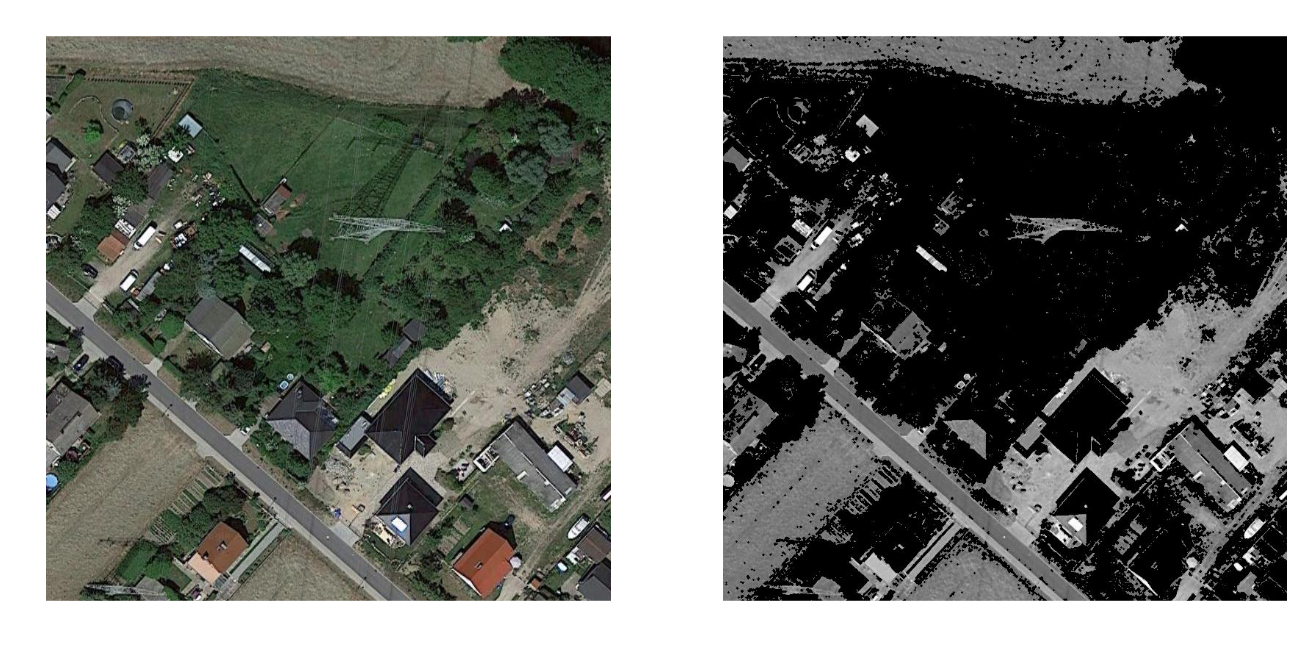

In [192]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all', squeeze=True, figsize=(16, 8))
ax1.axis('off')
ax2.axis('off')

ax1.imshow(raw_collection[sample_no])
ax2.imshow(processed_collection[sample_no], cmap='gray')
plt.show()

In [242]:
window_size = (140, 140)
stride = (35, 35)

In [243]:
# image = processed_collection[sample_no]
image = img.copy()

sw = view_as_windows(image, window_size, stride)
sw_shape = sw.shape

# fig, axes = plt.subplots(sw.shape[0], sw.shape[1], sharex='all', sharey='all', squeeze=True, figsize=(16, 16))

# for i in range(sw.shape[0]):
#     for j in range(sw.shape[1]):
#         axes[i, j].axis('off')
#         axes[i, j].imshow(sw[i, j])

# plt.show()


sw = sw.reshape((sw_shape[0] * sw_shape[1], sw_shape[2], sw_shape[3], 1))

predictions = model.predict(sw, batch_size=32, verbose=1)

# print(predictions)

# del image, sw

134672/134672 [==============================] - 539s   


In [250]:
predictions

array([[ 0.26894143,  0.7310586 ],
       [ 0.26894143,  0.7310586 ],
       [ 0.26894143,  0.7310586 ],
       ..., 
       [ 0.7310586 ,  0.26894143],
       [ 0.7310586 ,  0.26894143],
       [ 0.7310586 ,  0.26894143]], dtype=float32)

In [247]:
y = predictions.copy()
# y[y < 0.5] = 0
y = np_utils.categorical_probas_to_classes(y)
y = y.reshape(sw_shape[0], sw_shape[1])

In [248]:
y.shape
np.bincount(y.reshape((sw_shape[0] * sw_shape[1], )))

array([53401, 81271])

In [249]:
im = Image.open('/home/tanuj/Workspace/power-grid-detection/dataset/test/3.jpg')

drawable = ImageDraw.Draw(im)

for i in range(sw_shape[0]):
    for j in range(sw_shape[1]):
        if y[i, j]:
            drawable.rectangle(
                (i * stride[0], 
                 j * stride[1], 
                 i * stride[0] + window_size[0], 
                 j * stride[1] + window_size[1]),
                outline='red'
            )

im.save('/home/tanuj/Workspace/power-grid-detection/dataset/test/3_res.jpg', 'JPEG')

TypeError: Invalid dimensions for image data

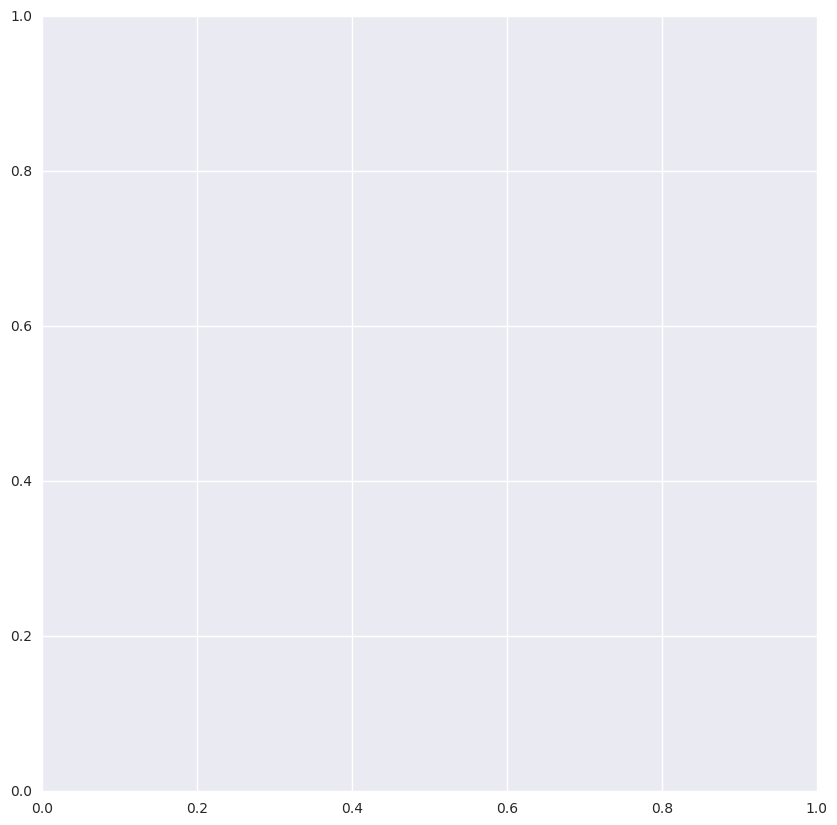

In [219]:
fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(10, 10))

# ax.imshow(raw_collection[sample_no])
ax.imshow(processed_collection[sample_no])

for i in range(sw_shape[0]):
    for j in range(sw_shape[1]):
        if y[i, j] == 0:
            patch = patches.Rectangle(
                (i * stride[0], j * stride[1]), 
                window_size[0],
                window_size[1],
                fill=False,
                edgecolor="red"
            )

            ax.add_patch(patch)
#         else:
#             print('Haw')

plt.show()

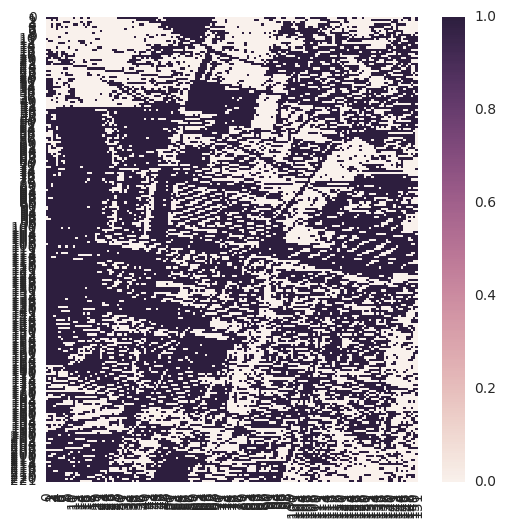

In [221]:
plt.figure(figsize=(6, 6))
ax = sns.heatmap(y)

plt.show()

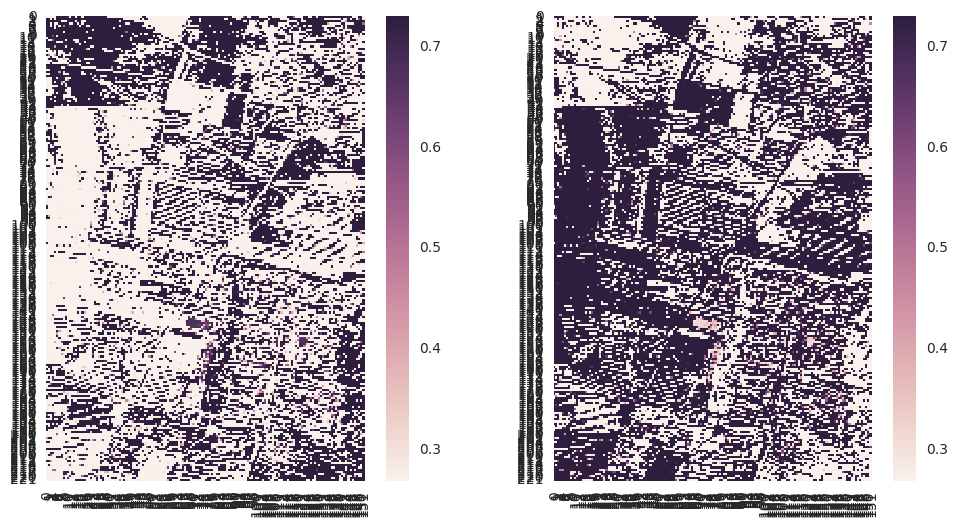

In [222]:
y_o = predictions[:, 0]
y_1 = predictions[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(y_o.reshape(sw_shape[0], sw_shape[1]), ax=ax1, square=True)
sns.heatmap(y_1.reshape(sw_shape[0], sw_shape[1]), ax=ax2, square=True)
plt.show()

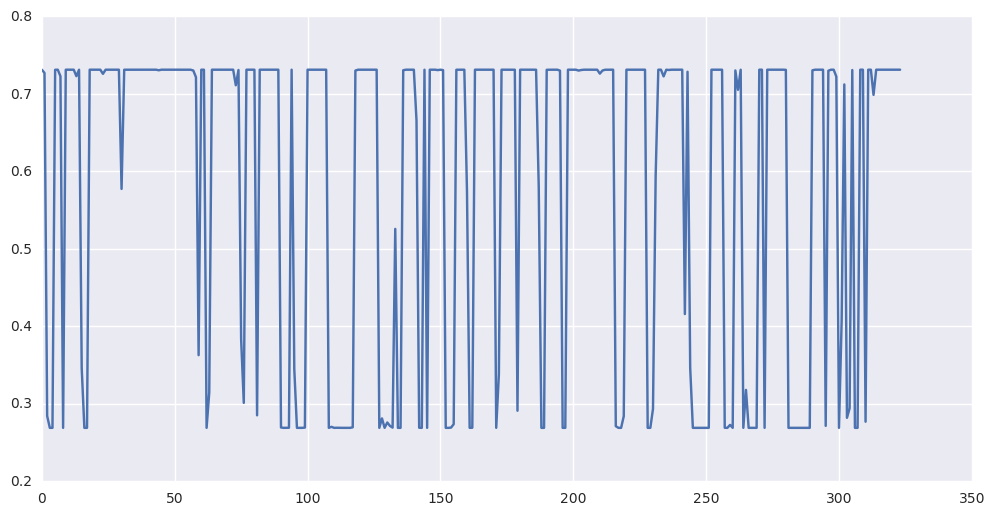

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(predictions[:, 1])